# Concentration dependent elastic constants

Here we demonstrate the new `SQSElasticConstantsList` job, which gets elastic constants as a function of chemical composition.

This job works by using special quasirandom structures (implemented by Dominik Gehringer and Jan Janssen) to create cells with the requested chemical composition from a base crystal structure. These are then evaluated for their elastic constants (implemented by Yuri Lysogorskiy). These are fully relaxed and the basic output is the chemical composition and full 6x6 elastic matrix. (More detailed output is available from the underlying `SQSElasticConstants` job stored in HDF5, but user-friendly bindings are not currently implemented.)

These components were assembled together in a single job (implemented by Liam Huber) that takes a list of dictionaries giving the desired chemical compositions (e.g. `{'Al': 0.95, 'Mg': 0.04, '0': 0.01}` for 95% Aluminium 4% Magnesium and 1% vacancies) and three reference jobs: a `ref_ham` which says how the structures should be interpreted for forces and energies (e.g. a Lammps job with a particular potential) -- the structure of this job provides the base crystal upon which the chemical compositions are imposed -- and `ref_sqs` and `ref_elastic` which hold the input parameters for the SQS and elastic constant calculation components.

The current implementation only facilitates modal run modes and is not heavily tested. The example below takes less than 30 minutes on a single core, so for the purposes of demonstration this is not a serious limitation.

**some instruction before running this notebook**  
Please first, make sure you have configure pyiron. you can symply run.
```
import pyiron
pyiron.install()# then input yes
```  
Then you need to build lammps. I suggest to clone lammps repository and build it.
```
git clone lammps
git checkout stable
cd src
make serial
cp lmp_serial ~/pyiron/resources//pyiron/resources/lammps/bin
```  
Then you need to clone pyiron repository
```
git clone https://github.com/pyiron/pyiron <the path to save pyiron repository>
```
Finally place this notebook and the enclosing notebook inside `pyiron/projects/`
```
cp -r ../from_liam ~/pyiron/projects/
```
Then run this notebook from there :)


In [1]:
import sys
#type(sys.path)

In [2]:
sys.path = ['/home/pyiron_user/git-repo/pyiron']+sys.path #please replace this with <path of pyiron repository>

In [3]:
sys.path[0]='/home/pyiron_user/pyiron/projects/from_liam' #please replace this with <path to this notebook> probably ~/pyiron/projects/from_liam/
sys.path[1]='/home/pyiron_user/git-repo/pyiron' #please replace this with <path of pyiron repository> 
print(sys.path)

['/home/pyiron_user/pyiron/projects/from_liam', '/home/pyiron_user/git-repo/pyiron', '/opt/conda/lib/python38.zip', '/opt/conda/lib/python3.8', '/opt/conda/lib/python3.8/lib-dynload', '', '/opt/conda/lib/python3.8/site-packages', '/opt/conda/lib/python3.8/site-packages/IPython/extensions', '/home/pyiron_user/.ipython']


In [4]:
#!conda install -y --quiet seaborn
from pyiron import Project
import pyiron_mpie
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import sys
sys.path.append('.')
from sqselastic import SQSElasticConstantsList

In [5]:
pr = Project('elastic_pipeline')
#pr.remove_jobs(recursive=True)

## Run the calculation

Our test system will be Al with dilute Mg (up to 2%). Here we define the reference jobs, give our desired compositions.

Feedback on the most user-friendly way to take chemical composition input (while still being fully flexible in allowed compositions!) is welcome -- this code is still in development.

In [6]:
lammps = pr.create_job(pr.job_type.Lammps, 'lammps')
lammps.structure = pr.create_ase_bulk('Al', cubic=True).repeat(5)
lammps.potential = 'Al_Mg_eam_fs'

# sqs = pr.create_job(pr.job_type.SQSJob, 'sqs')
# sqs.structure = lammps.structure.copy()
# sqs.input.mole_fractions = {'Al': 0.98, 'Mg':0.02}
# sqs.run() 
sqs = pr.create_job(pr.job_type.SQSJob, 'sqs')
sqs.input.iterations = 1000
sqs.input.weights = None
sqs.input.n_output_structures = 1  # SQSJob Bug?: only 1 structure is being used regardless

elastic = pr.create_job(pr.job_type.ElasticMatrixJob, 'elastic')
elastic.input['num_of_points'] = 5
elastic.input['fit_order'] = 2
elastic.input['eps_range'] = 0.005
elastic.input['relax_atoms'] = True
elastic.input['sqrt_eta'] = True
# TODO: Get an updated version of ElasticMatrixJob that is public and uses InputList

job = pr.create_job(SQSElasticConstantsList, 'chemical')
job.ref_ham = lammps
job.ref_sqs = sqs
job.ref_elastic = elastic
job.input.chemistry = [
    {'Al': 1., 'Mg': 0.}, 
    {'Al': 0.995, 'Mg': 0.005}, 
    {'Al': 0.99, 'Mg': 0.01}, 
    {'Al': 0.985, 'Mg': 0.015}, 
    {'Al': 0.98, 'Mg': 0.02}, 
]

job.run()
# TODO: Test submitting a job on the server.
# Settings here take 20 minutes on a single core

2020-10-28 20:09:39,967 - pyiron_log - WARNING - The job chemical is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


## post-processing the data

The output of the job is stored to HDF5. To verify this, and since the actual calculation may be done at a different time than the results are analyzed, we demonstrate this by loading the job.

There is also a little bit of annoying post-processing to get it all formatted as nice numpy arrays. Some of this is reasonable (like the need to explicitly add 0% Mg to the first chemistry -- we wouldn't want to list *everything that's not there*!), some is "not my fault" (like the way the InputList class mangles our chemistry dictionary on saving it to HDF), and some needs nicer helper functions in the future (like the ability to explicity ask for "C12" and get it by that string).

In [7]:
loaded = pr.load('chemical')  # Job saves and loads fine

In [8]:
loaded.output.chemistry[0]['Mg'] = 0.  # Add a zero Mg term to the pure-Al structure
concentrations = np.array([
    loaded.output.chemistry[int(i)]['Mg'] 
    for i in np.arange(len(loaded.output.chemistry))
])
# InputList 'feature': after saving to HDF, lists, dicts, etc get wrapped as "InputList"
# This makes reading them a pain in the butt ^^
elastic_matrices = np.array(loaded.output.elastic_matrices)
C11_data = elastic_matrices[:, 0, 0]
C12_data = elastic_matrices[:, 0, 1]
C44_data = elastic_matrices[:, 3, 3]

## Analysis

Finally, let's use numpy to make a polynomial fit of our elastic constants to alloying concentration and visualize the results.

Note: pure-Al data lines up very nicely with the pure Al elastic constants [reported on the NIST website for this potential](https://www.ctcms.nist.gov/potentials/entry/2009--Mendelev-M-I-Asta-M-Rahman-M-J-Hoyt-J-J--Al-Mg/2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1.html). I don't have a good sense for exactly what <2% Mg should be doing, but at least there are no sharp changes. Sanity check passed.

In [9]:
fit_degree = 2
C11_fit = np.polyfit(concentrations, C11_data, deg=fit_degree)
C12_fit = np.polyfit(concentrations, C12_data, deg=fit_degree)
C44_fit = np.polyfit(concentrations, C44_data, deg=fit_degree)
c = np.linspace(concentrations.min(), concentrations.max(), 100)  # 'Continuous' concentration

In [10]:
# p(x) = p[0] * x**deg + ... + p[deg]
print(C11_fit)
print(C12_fit)
print(C44_fit)

[3835.26298799  -89.78171797  110.34510588]
[506.86040541 230.82117133  61.73911807]
[135.24677091  45.19053689  32.72377752]


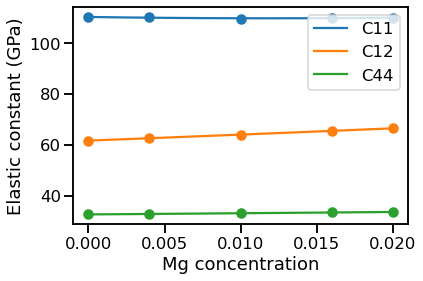

In [11]:
for color, data, fit, label in zip(
    sns.color_palette(n_colors=3), 
    [C11_data, C12_data, C44_data], 
    [C11_fit, C12_fit, C44_fit],
    ['C11', 'C12', 'C44']
):
    plt.scatter(concentrations, data, color=color)
    plt.plot(c, np.polyval(fit, c), color=color, label=label)
plt.xlabel('Mg concentration')
plt.ylabel('Elastic constant (GPa)')
plt.legend()
plt.show()

# DAMASK Simulations
The steps include, defining:
- geometries
- grains
- loading
- material properties based on the atomistically-evaluated 
- perfoming simulations

In [13]:
concentrations=[0.,0.01,0.02]

In [14]:
from damask import Geom
from damask import seeds
#import numpy as np
import subprocess,shlex
import os
import damask
from simulation_runner import simulation
simulation_folder =[]
job_file = []
grid = np.array([16,16,16])
size = np.array([1.0,1.0,1.0])
grains = 20
seeds = seeds.from_random(size,grains)
for i,c in enumerate(concentrations):
    os.chdir('/home/pyiron_user/pyiron/projects/from_liam/')
    simulation_folder.append('Mg-{}'.format(int(c*100)))
    os.system('mkdir {}'.format(simulation_folder[i]))
    os.system('cp Examples/material.yaml {}'.format(simulation_folder[i]))
    os.system('cp Examples/tensionX.load {}'.format(simulation_folder[i]))
    C11 = float(np.polyval(C11_fit, c))
    C12 = float(np.polyval(C12_fit, c))
    C44 = float(np.polyval(C44_fit, c))
    print(simulation_folder[i])
    os.chdir(simulation_folder[i])
    load = 'tensionX.load'
    geom_name = 'test.geom'
    material_config = 'material.yaml'
    job_file.append('{}_{}.hdf5'.format(geom_name.split('.')[0],load.split('.')[0]))
    new_geom = Geom.from_Voronoi_tessellation(grid,size,seeds)
    new_geom.save_ASCII(geom_name)
    new_geom.save(geom_name.split('.')[0])
    C_matrix = [C11*1e9,C12*1e9,C44*1e9]
    elasticity={}
    elasticity.update({'type': 'hooke'})
    elastic_constants = {'C_11': C_matrix[0], 'C_12': C_matrix[1], 'C_44': C_matrix[2]}
    elasticity.update(elastic_constants)
    mat = damask.Config.load(material_config)
    mat['phase']['Aluminum']['elasticity'] = elasticity
    mat.save(material_config)
    simulation.run(simulation_folder[i],geom_name,load)
    print('simulation {} done'.format(str(i)))
    

Mg-0
simulation 0 done
Mg-1
simulation 1 done
Mg-2
simulation 2 done


## Post-processing DAMASK simulations
- Von-Mises stress for each case is calculated
- The Stress-strain data is evaluated for each case


In [29]:
import damask
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as PyPlot
import numpy as np
import h5py
from Plot_stress_strain import plot
from damask_eval import eval_stress , eval_strain
%matplotlib inline
d = []
stresses = []
strains = []
for i,c in enumerate(concentrations): 
    os.chdir('/home/pyiron_user/pyiron/projects/from_liam/')
    os.chdir(simulation_folder[i])
    d.append(damask.Result(job_file[i]))                  
    d[i].add_Cauchy()
    d[i].add_strain_tensor()
    d[i].add_Mises('sigma')
    d[i].add_Mises('epsilon_V^0.0(F)')
    d[i].add_calculation('avg_sigma',"np.average(#sigma_vM#)")
    d[i].add_calculation('avg_epsilon',"np.average(#epsilon_V^0.0(F)_vM#)")
    d[i].save_vtk(['sigma','epsilon_V^0.0(F)','sigma_vM','epsilon_V^0.0(F)_vM'])
    stresses.append(eval_stress(job_file[i]))
    strains.append(eval_strain(job_file[i]))

 █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   2% ETA 0:00:04

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   5% ETA 0:00:10

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ███░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   6% ETA 0:00:04

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 █████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  19% ETA 0:00:03

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  41% ETA 0:00:01

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ███████████████████████████████████████████░░░░░░░  86% ETA 0:00:00

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   5% ETA 0:00:03

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ███████████████████████████░░░░░░░░░░░░░░░░░░░░░░░  54% ETA 0:00:00

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   5% ETA 0:00:03

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ███████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  38% ETA 0:00:00

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   2% ETA 0:00:04

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  25% ETA 0:00:01

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   5% ETA 0:00:02

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ███████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  31% ETA 0:00:01

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   0% ETA n/a

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
/home/pyiron_user/pyiron/projects/from_liam/damask_eval.py:37: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf = h5py.File(d.fname)
 █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   2% ETA 0:00:10

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  32% ETA 0:00:01

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ███░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   6% ETA 0:00:05

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  25% ETA 0:00:02

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░  44% ETA 0:00:01

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   5% ETA 0:00:03

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 █████████████████████████████░░░░░░░░░░░░░░░░░░░░░  58% ETA 0:00:00

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   2% ETA 0:00:07

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 █████████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░  51% ETA 0:00:00

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   5% ETA 0:00:03

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 █████████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░  51% ETA 0:00:00

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   2% ETA 0:00:02

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  25% ETA 0:00:01

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   0% ETA n/a

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   0% ETA n/a

Could not add dataset: Unable to create link (name already exists).


 █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   2% ETA 0:00:16

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   5% ETA 0:00:04

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  16% ETA 0:00:03

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).

 █████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  43% ETA 0:00:01


Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (n

 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   2% ETA 0:00:03

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   5% ETA 0:00:08

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   2% ETA 0:00:05

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  32% ETA 0:00:01

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   5% ETA 0:00:03

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ███████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░  47% ETA 0:00:00

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   2% ETA 0:00:04

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).


 ██████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  28% ETA 0:00:01

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   0% ETA n/a

Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (name already exists).
Could not add dataset: Unable to create link (na

 ██████████████████████████████████████████████████ 100% ETA 0:00:00


## Visualization
### Von-Mises Stress

In [49]:
import pyvista as pv
inc=20
os.chdir('/home/pyiron_user/pyiron/projects/from_liam/')
os.chdir(simulation_folder[0])
mesh = pv.read(job_file[0].split('.')[0] + f'_inc{inc}.vtr')  #enter the file name you wish to view

In [50]:
from itkwidgets import view
import itk
mesh

RectilinearGrid (0x7f171d51b0a0)
  N Cells:	4096
  N Points:	4913
  X Bounds:	0.000e+00, 1.000e+00
  Y Bounds:	0.000e+00, 1.000e+00
  Z Bounds:	0.000e+00, 1.000e+00
  Dimensions:	17, 17, 17
  N Arrays:	5

In [51]:
pl = pv.PlotterITK()
pl.add_mesh(mesh)
pl.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

### Stress-strain curve

The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


Text(0.5, 1.0, 'Stress-Strain')

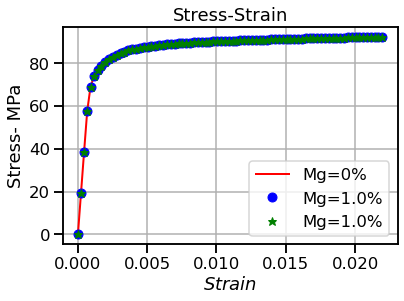

In [57]:
import matplotlib.pyplot as plt
i = 0;
stresses[0]= eval_stress(job_file[0])
stresses[1]= eval_stress(job_file[1])
stresses[2]= eval_stress(job_file[2])
colors = ['r','g','b']
#for color, strain, stress, c in zip(colors, strains, stresses, concentrations):
plt.plot(strains[0], stresses[0], 'r', linewidth=2, label = 'Mg={}%'.format(0*100))
plt.plot(strains[1], stresses[1], 'b', linestyle="None",marker = 'o' ,label = 'Mg={}%'.format(0.01*100))
plt.plot(strains[1], stresses[2], 'g', linestyle="None",marker = '*' ,label = 'Mg={}%'.format(0.01*100))
#plt.ylim(90, 95)
plt.grid(True)
plt.xlabel('$Strain$')
plt.ylabel('Stress- MPa')
plt.legend( loc='lower right')
plt.title("Stress-Strain")
 #   i= i+1;